# Transfer learning

Phương pháp được xây dựng dựa trên ý tưởng chuyển giao tri thức đã được học từ những mô hình tốt trước đó, đã được pre-train từ trước. Một mô hình đã có khả năng tận dụng lại các tri thức đã huấn luyện trước đó và cải thiện lại trên tác vụ phân loại của nó

Có nhiều các pretrained-model có chất lượng tốt và độ chính xác cao, giúp tiết kiệm chi phí huấn luyện. Hầu như mọi domain đều có thể tìm kiếm được các pretrained-model.
- Có điểm khởi đầu của accuracy tốt hơn (higher start).
- Accuracy có tốc độ tăng nhanh hơn (higher slope).
- Đường tiệm cận của độ chính xác tối ưu cao hơn (higher asymptote).

![](https://phamdinhkhanh.github.io/assets/images/20200415_TransferLearning/pic1.jpg)

**1. Nguyên nhân mô hình dự báo kém**
- __Dữ liệu nhỏ không đại diện__: Bộ dữ liệu của chúng ta có kích thước quá bé. Do đó mô hình được huấn luyện không học được các đặc trưng tổng quát để áp dụng vào các tác vụ phân loại. Ví dụ: Cùng là bài toán phân loại chó và mèo nhưng dữ liệu của bạn chỉ có 100 ảnh chó và ảnh mèo của Việt Nam. Số lượng này còn ít hơn số lượng các loài chó và mèo trên thế giới. Nếu áp dụng mô hình được huấn luyện trên bộ dữ liệu nhỏ sẽ dẫn tới khả năng dự báo sai trên những dữ liệu mới cao hơn.

- __Mô hình mất cân bằng dữ liệu__: Khi mô hình mất cân bằng dữ liệu thì việc dự đoán các mẫu thuộc nhóm thiểu số khó khăn hơn. 

- __Kiến trúc mô hình quá phức tạp__: Đối với những bộ dữ liệu lớn lên tới vài triệu ảnh thì mô hình có kiến trúc phức tạp có thể mang lại độ chính xác cao. Nhưng với những bộ dữ liệu kích thước nhỏ thì mô hình phức tạp lại giảm độ chính xác. Mình cho rằng nguyên nhân chính là bởi các mô hình phức tạp thường xảy ra overfitting.

- __Quá trình tối ưu hóa gặp khó khăn__: Có thể bạn đã thiết lập learning rate chưa tốt nên khiến mô hình huấn luyện lâu hội tụ hoặc chưa đạt tới điểm global optimal. Khi đó bạn có thể cân nhắc thay đổi phương pháp cập nhật gradient descent và thiết lập schedule learning rate. Trên `tensorflow.keras` chúng ta có thể thiết lập schedule learning thông qua `CheckPoint` như sau:
```python
import tensorflow as tf

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
your_model.fit(data, labels, epochs=100, callbacks=[callback],
          validation_data=(val_data, val_labels))
```

**2. Hiệu quả với dữ liệu nhỏ**

Trong trường hợp bộ dữ liệu có kích thước quá nhỏ và khó có thể tìm kiếm và mở rộng thêm thì các mô hình được huấn luyện từ chúng sẽ khó có thể dự báo tốt. Tận dụng lại tri thức từ các pretrained-model với cùng tác vụ phân loại sẽ giúp các mô hình được huấn luyện dự báo tốt hơn với dữ liệu mới vì mô hình được học trên cả 2 nguồn tri thức đó là dữ liệu huấn luyện và dữ liệu mà nó đã được học trước đó.

**3. Kiến trúc mạng transfer learning**

[Chi tiết](https://phamdinhkhanh.github.io/2020/04/15/TransferLearning.html#22-ki%E1%BA%BFn-tr%C3%BAc-m%C3%B4-h%C3%ACnh-s%E1%BB%AD-d%E1%BB%A5ng-transfer-learning)

**4. Kinh nghiệm với TL**
- __4.1. Transfer learning theo kích thước dữ liệu__: Các đặc trưng học được trên ít dữ liệu sẽ có tác dụng phân loại kém hơn so với các đặc trưng được trên bộ dữ liệu kích thước lớn. Do đó:
    - ___Đối với dữ liệu nhỏ___: Train lại toàn bộ các layers sẽ làm mất đi các đặc trưng đã được học từ model pretrained và dẫn tới mô hình dự báo sẽ không chính xác. Chúng ta chỉ nên train lại các fully connected layers cuối.
    - ___Đối với dữ liệu lớn và giống domain___: Có thể train lại model trên toàn bộ layers. Nhưng để quá trình huấn luyện nhanh hơn thì chúng ta sẽ thực hiện bước khởi động (warm up) và sau đó mới fine tuning lại mô hình.
    - ___Đối với dữ liệu lớn và khác domain___: Chúng ta nên huấn luyện lại model từ đầu vì pretrain-model không tạo ra được các đặc trưng tốt cho dữ liệu khác domain.
![](https://phamdinhkhanh.github.io/assets/images/20200415_TransferLearning/pic5.jpg)

- __4.2. Khi nào thực hiện transfer learning__:
    - Chỉ nên transfer learning giữa 2 mô hình có cùng domain. pretrained-model A và mô hình cần huấn luyện B không có chung domain về dữ liệu thì các đặc trưng học được từ bộ feature extractor của A sẽ không thực sự hữu ích trong việc phân loại của mô hình B. Cụ thể hơn. Nếu bạn muốn xây dựng một ứng dụng âm thanh đánh thức trợ lý ảo của google bằng tiếng Việt khi nói từ :”dậy đi google”. Bạn đã có sẵn pretrained-model A đối với tác vụ speech to text nhưng huấn luyện trên Tiếng Anh. Như vậy bạn không nên thực hiện transfer learning trong trường hợp này. Như trong ví dụ của mình thì pretrained-model của imagenet đã bao gồm 2 classes dog and cat.

    - Dữ liệu huấn luyện pretrained-model A phải lớn hơn so với mô hình B. Nếu chúng ta transfer hệ số từ một pretrained-model được huấn luyện trên dữ liệu có kích thước nhỏ thì các đặc trưng học được từ mô hình A sẽ không tổng quát để giúp ích phân loại dữ liệu mô hình B.

    - Pretrained-model A phải là mô hình có phẩm chất tốt. Đây là một yêu cầu hiển nhiên vì mô hình tốt mới tạo ra được những đặc trưng tốt.

## Ví dụ

Phân loại ảnh chó mèo

### Dataset
Dữ liệu được sử dụng để minh họa cho phương pháp transfer learning là bộ dữ liệu __Sub Dog and Cat__ với khoảng 1400 ảnh.

In [1]:
%cd Datasets
!git clone https://github.com/ardamavi/Dog-Cat-Classifier.git
%cd Dog-Cat-Classifier

Cloning into 'Dog-Cat-Classifier'...
remote: Enumerating objects: 1654, done.
remote: Total 1654 (delta 0), reused 0 (delta 0), pack-reused 1654
Receiving objects: 100% (1654/1654), 34.83 MiB | 2.43 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/Users/datkhong/Library/CloudStorage/GoogleDrive-k55.1613310017@ftu.edu.vn/My Drive/GitCode/My_learning/1. DA - DS/3. Learning/2_Notebooks/5_Deep_learning/Dog-Cat-Classifier


In [2]:
!pwd

/Users/datkhong/Library/CloudStorage/GoogleDrive-k55.1613310017@ftu.edu.vn/My Drive/GitCode/My_learning/1. DA - DS/3. Learning/2_Notebooks/5_Deep_learning/Datasets/Dog-Cat-Classifier


<Axes: >

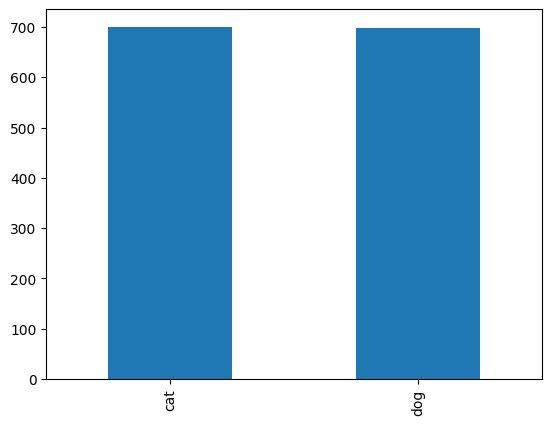

In [4]:
# khảo sát data
import pandas as pd
import glob2
import matplotlib.pyplot as plt

dogs = glob2.glob('Data/Train_Data/dog/*.jpg')
dog_labels = ['dog']*len(dogs)
cats = glob2.glob('Data/Train_Data/cat/*.jpg')
cat_labels = ['cat']*len(cats)

labels = dog_labels + cat_labels
image_links = dogs + cats

data = pd.DataFrame({'labels': labels, 'image_links':image_links})
data.groupby(labels).image_links.count().plot.bar()

Dữ liệu cân bằng giữa 2 label

In [5]:
# Phân chia tập train/validation

from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 1049, image_test shape: 350


### Data Augumentation

__Lưu ý__: Khi khởi tạo Data Generator với các mô hình sử dụng pretrained model thì chúng ta sẽ phải thực hiện các bước biến đổi dữ liệu trong data pipeline đồng nhất với pipeline được áp dụng trên pretrained model. Khi đó các đặc trưng được tạo thành từ base network mới có tác dụng phân loại tốt.

Các phép biến đổi trên tập train và validation mình đã tham chiếu với biến đổi mà tác giả sử dụng khi thực hiện model pretrain với bộ dữ liệu imagenet từ trước.

In [6]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        index2class: index của các class
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        n_classes: số lượng các class 
        normalize: có chuẩn hóa ảnh hay không?
        zoom_range: khoảng scale zoom là một khoảng nằm trong [0, 1].
        rotation: độ xoay ảnh.
        brightness_range: Khoảng biến thiên cường độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, y = self.__data_generation(all_filenames_temp)

        return X, y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu
        for i, fn in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            img_reshape = img.reshape(-1, 3)
            
            if self.normalize:
                # Có thuẩn hóa mỗi một ảnh với theo phân phối chuẩn bằng cách trừ đi trung bình 
                # và chia cho phương sai toàn bộ các pixels tương ứng ở mỗi kênh.
                mean = np.mean(img_reshape, axis=0)
                std = np.std(img_reshape, axis=0)
                img = (img-mean)/std

            if self.zoom_range:
                # Là một khoảng giá trị phóng đại ảnh: [lower, upper]. 
                # Giá trị phóng đại của một ảnh sẽ được sinh ngẫu nhiên nằm trong khoảng zoom_range. 
                # Giá trị phóng đại này càng nhỏ thì ảnh sẽ càng được phóng to.
                zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
                (h, w, c) = img.shape
                img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
                (h_rz, w_rz, c) = img.shape
                start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
                start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
                # print(start_w, start_h)
                img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
                # Góc xoay ngẫu nhiên của một bức ảnh. Thông thường chỉ thiết lập từ 10-20 độ.
                (h, w, c) = img.shape
                angle = np.random.uniform(-self.rotation, self.rotation)
                RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
                img = cv2.warpAffine(img, RotMat, (w, h))

            if self.brightness_range:
                # Khoảng điều chỉnh độ sáng cho bức ảnh. Độ sáng sẽ là một giá trị ngẫu nhiên từ [minVal, maxVal].
                scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
                img = img*scale_bright
            
            label = 'dog' if 'dog' in fn else 'cat'
            label = self.index2class[label]
    
            X[i,] = img

            # Lưu class
            y[i] = label
        return X, y

dict_labels = {
    'dog': 0,
    'cat': 1
}

train_generator = DataGenerator(
    all_filenames = images_train,
    labels = y_label_train,
    batch_size = 32,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 16,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range =[0.8, 1],
    shuffle = False
)

__Kiểm tra dữ liệu Augumentation__

Chúng ta không nên tin hoàn toàn vào Augumentation mà cần khảo sát lại xem những step biến đổi trên pipeline đã thay đổi dữ liệu như thế nào? Những biến đổi đó có tạo ra các mẫu phù hợp với thực tế không? Đây là một qui trình cần thiết khi huấn luyện mô hình.

Để kiểm tra pipeline của ImageGenerator chúng ta có thể khởi tạo vòng lặp loop qua Generator:

In [29]:
root = r"/Users/datkhong/Library/CloudStorage/GoogleDrive-k55.1613310017@ftu.edu.vn/My Drive/GitCode/My_learning/1. DA - DS/3. Learning/2_Notebooks/5_Deep_learning/"

check_aug=[root + r'Datasets/Dog-Cat-Classifier/Data/Train_Data/cat/cat.100.jpg']*32

check_generator = DataGenerator(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = 15,
    brightness_range = [0.5, 1.5],
    shuffle = False
)

X_batch, y_batch = check_generator.__getitem__(0)
print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20,)


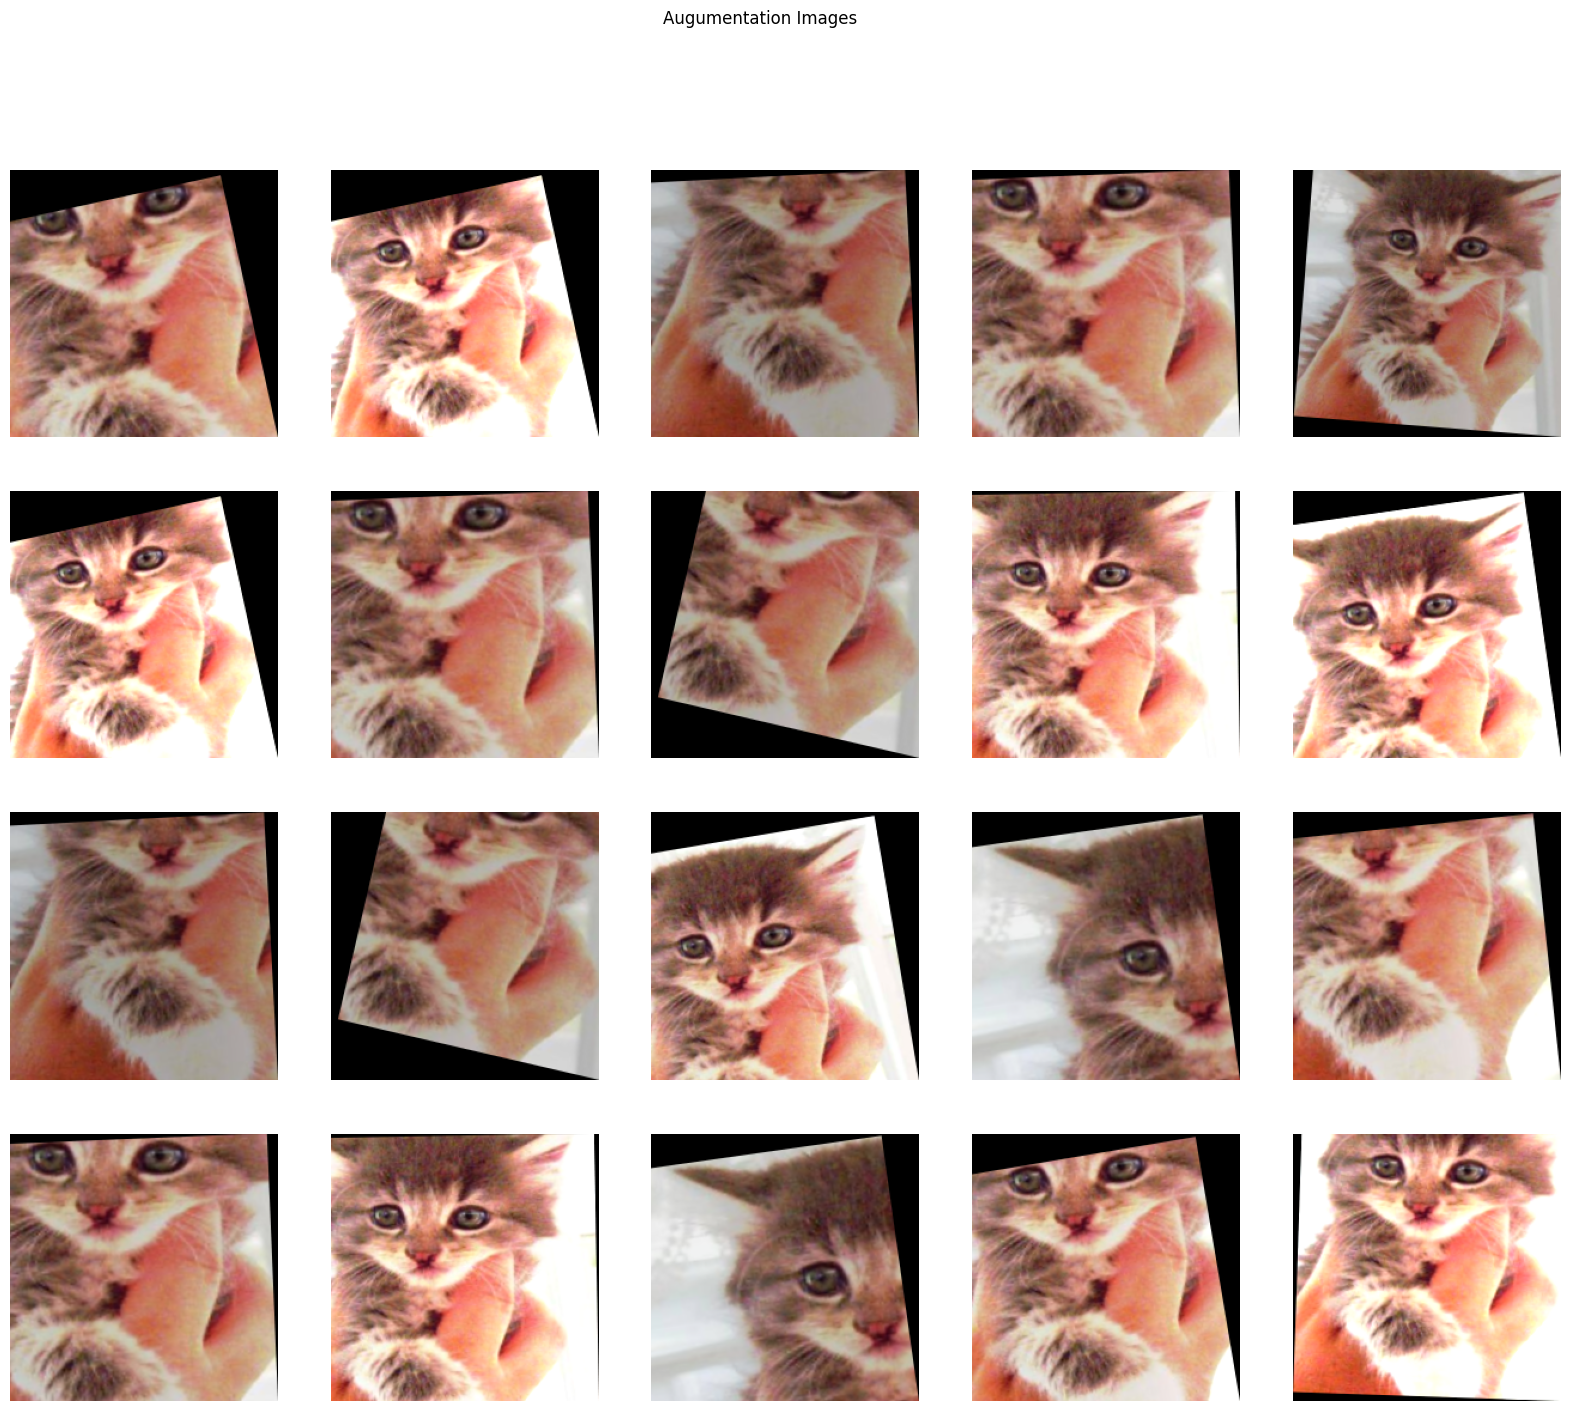

In [31]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
    for j in np.arange(5):
        ax[i, j].imshow(X_batch[i + j + j*i]/255.0)
        ax[i, j].set_xlabel('Image '+str(i+j+j*i))
        ax[i, j].axis('off')
plt.show()

### Train model

Tiếp theo chúng ta sẽ huấn luyện mô hình. Việc đầu tiên cần thực hiện là khởi tạo base network cho mô hình. Trên keras đã có hầu hết các model pretrain phổ biến trên bộ dữ liệu imagenet. Lý do tác giả lựa chọn bộ dữ liệu này để huấn luyện các pretrained-model là vì có tới 1000 classes khác nhau. Do đó hầu như mọi bài toán classification đều có nhãn xuất hiện trong imagenet và có thể tái sử dụng pretrained-model.

In [30]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam


base_network = MobileNet(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
flat = Flatten()
den = Dense(1, activation='sigmoid')

model = Sequential([base_network, 
                    flat,
                    den])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Metal device set to: Apple M1 Pro


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________


Để ý kĩ bạn sẽ thấy __base network__ là một pretrain __model Mobilenet__ đã được `truncate` top layer thông qua tham số `include_top=False`. Bài toán của chúng ta có số lượng nhãn khác với imagenet nên sẽ ta gán vào __base network__ một mạng __MLP__ gồm các __Layers Fully Connected__ sao cho layer cuối có số __units = số lượng output classes__.

### Warm up

thực hiện quá trình warm up để huấn luyện mô hình nhanh hơn.

Warm up là quá trình cần thiết để mô hình hội tụ nhanh hơn. Warm up sẽ đóng băng lại các layers CNN để cho hệ số của chúng không đổi và chỉ train lại trên các Fully Conntected Layers ở cuối cùng. Mục đích của warm up là giữ nguyên được các đặc trưng bậc cao (high-level) đã được học từ pretrained-model mà những đặc trưng này là tốt vì được huấn luyện trên bộ dữ liệu có kích thước lớn hơn và có độ chính xác cao hơn sao với khởi tạo hệ số ngẫu nhiên. Như vậy Phrase 2 (xem hình 2) của mô hình sẽ không thay đổi input X và coi như chúng ta huấn luyện lại mạng MLP.

![](https://phamdinhkhanh.github.io/assets/images/20200415_TransferLearning/pic3.jpg)
![](https://phamdinhkhanh.github.io/assets/images/20200415_TransferLearning/pic4.jpg)

In [32]:
# Frozen base_network
model.layers[0].trainable = False

for layer in model.layers:
    print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x2922431c0> ; Trainable: False
Layer: <keras.layers.reshaping.flatten.Flatten object at 0x128591330> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x292242a10> ; Trainable: True


In [36]:
# Huấn luyện lại model trên 1 epoch
import tensorflow as tf

model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=1)

32/32 [==============================] - 6s 170ms/step - loss: 0.2725 - accuracy: 0.9277 - val_loss: 2.5612 - val_accuracy: 0.8000


Bạn sẽ thấy accuracy sẽ được cải thiện rất nhanh chỉ sau epoch đầu tiên. Tuy nhiên bài toán có hiện tượng overfitting khi val_accuracy thấp hơn nhiều so với train_accuracy. Để giảm thiểu overfitting chúng ta sẽ thực hiện một số hiệu chỉnh đối với mô hình như:

- Mạng nơ ron có khả năng xấp xỉ được hầu hết các hàm số. Khi kiến trúc mạng càng phức tạp và bộ dữ liệu huấn luyện có kích thước nhỏ thì khả năng học được chính xác trên từng điểm dữ liệu sẽ rất tốt. Nhưng việc học này sẽ không tốt trên dữ liệu mới. Chúng ta có thể sử dụng Dropout Layer để giảm thiểu độ phức tạp trong kiến trúc của mô hình. Dropout sẽ làm nhiệm vụ cắt tỉa bớt một số kết nối Fully Connected.

- Để giảm thiểu mức độ phức tạp của hàm số chúng ta cũng có thể sử dụng các phương pháp hiệu chuẩn (regularization) bằng cách thêm vào loss function thành phần norm chuẩn Frobenius của ma trận hệ số các layers.

In [ ]:
from tensorflow.keras import regularizers
your_model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

Một trong những nguyên nhân chủ yếu của overfitting đó là dữ liệu huấn luyện có kích thước quá bé và không tổng quát các trường hợp của ảnh. Trên thực tế bộ dữ liệu dog and cat gốc có kích thước là 25000 ảnh và lớn gấp hàng chục lần dữ liệu huấn luyện với khoảng 1000 ảnh ảnh. Tăng cường thêm dữ liệu huấn luyện cho tập train là một giải pháp có thể cân nhắc tới.

Fine tuning lại những layers của base network để cải thiện đặc trưng (sẽ được trình bày ở phần sau).

### Fine tuning model

Mục đích chính của việc warm up model là để mô hình hội tụ nhanh hơn tới global optimal value. Sau khi mô hình đạt ngưỡng tối ưu trên các Fully Connected Layers, sẽ rất khó để chúng ta tăng được thêm độ chính xác hơn nữa. Lúc này chúng ta sẽ cần phá băng (unfrozen) các layers của base network và huấn luyện mô hình trên toàn bộ các layers từ pretrained- model. Quá trình này được gọi là fine tuning.

In [38]:
model.layers[0].trainable = True
for layer in model.layers:
    print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

model.fit(train_generator, validation_data = val_generator, batch_size = 32, epochs = 5)

Layer: <keras.engine.functional.Functional object at 0x2922431c0> ; Trainable: True
Layer: <keras.layers.reshaping.flatten.Flatten object at 0x128591330> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x292242a10> ; Trainable: True
Epoch 1/5
32/32 [==============================] - 6s 183ms/step - loss: 0.1417 - accuracy: 0.9600 - val_loss: 0.9506 - val_accuracy: 0.9196
Epoch 2/5
32/32 [==============================] - 6s 180ms/step - loss: 0.1339 - accuracy: 0.9648 - val_loss: 1.3298 - val_accuracy: 0.9018
Epoch 3/5
32/32 [==============================] - 6s 180ms/step - loss: 0.1287 - accuracy: 0.9492 - val_loss: 0.6633 - val_accuracy: 0.9256
Epoch 4/5
32/32 [==============================] - 6s 180ms/step - loss: 0.0750 - accuracy: 0.9727 - val_loss: 0.6217 - val_accuracy: 0.9137
Epoch 5/5
32/32 [==============================] - 6s 181ms/step - loss: 0.1726 - accuracy: 0.9658 - val_loss: 1.4123 - val_accuracy: 0.8929


Chúng ta có thể nhận thấy rằng sau khi thực hiện fine tunning thì đồng thời accuracy trên tập train và tập validation đều tăng và đạt tới ngưỡng >= 80%.

Như vậy fine tunning đã giải quyết được đồng thời 2 vấn đề overfitting và cải thiện accuracy của mô hình.

Đưa thêm hình về accuracy giữa transfer learning và mô hình gốc.